## iBot with ViT-B architecture with patch size=16

In [1]:
import sys
sys.path.append("../../../ssl")

In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as Transforms
import copy
import pickle
from augmentations.loader import get_dataloaders
from utils.eval import plot_cm_roc
from utils.eval import train
from utils.eval import test_
from models.classifier import Classifier
from utils import plot_history
from utils import set_seed
set_seed(12)

In [3]:
ckpt_path = "./ibot_vit_base_models/checkpoint.pth"
state = torch.load(ckpt_path, mmap="cpu")

#### Plot for train loss vs epochs

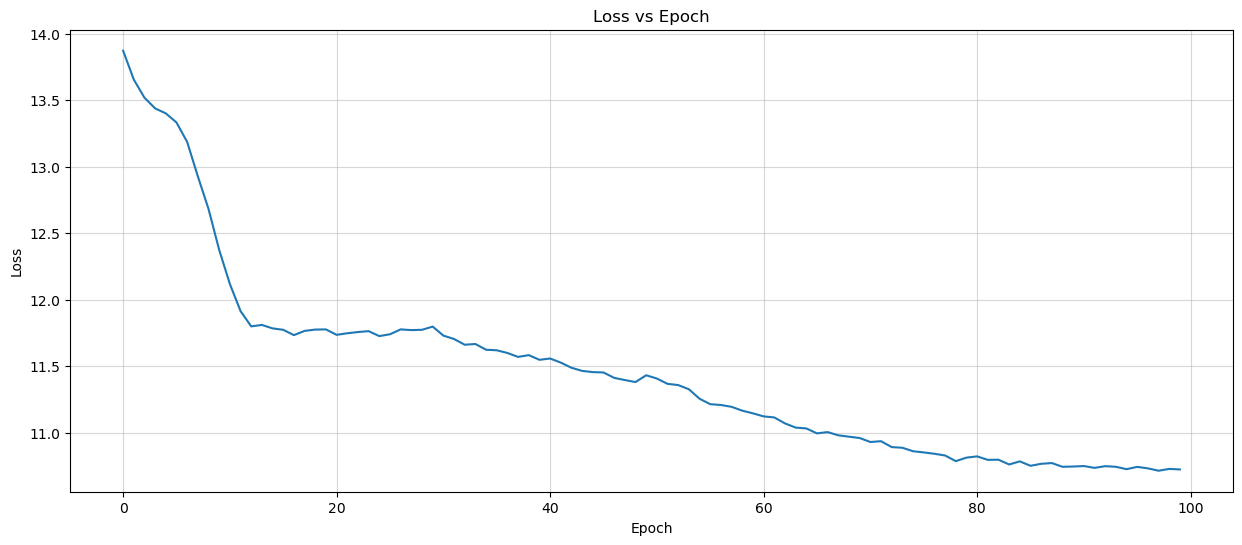

<Figure size 640x480 with 0 Axes>

In [4]:
plot_history(ckpt_path, "./train_history.png")

### Train model over the train dataset

In [5]:
eval_transforms = Transforms.Compose([
                        # Transforms.ToTensor(), # npy loader returns torch.Tensor
                        Transforms.CenterCrop(64),
                        Transforms.Normalize(mean = [0.06814773380756378, 0.21582692861557007, 0.4182431399822235],\
                                                std = [0.16798585653305054, 0.5532506108283997, 1.1966736316680908]),
                    ])
dataloader, train_loader, val_loader, test_loader \
        = get_dataloaders(data_path="../../../input/real_lenses_dataset/", \
                          train_test_indices="../../../input/indices.pkl", \
                          state=state, eval_transforms=eval_transforms)

### Finetune the pretrained model

In [6]:
set_seed(12)

state = torch.load("./ibot_vit_base_models/checkpoint.pth")
student_network = state["student"].backbone
lp_network = Classifier(mode = "finetune", backbone = copy.deepcopy(student_network), backbone_return_all_tokens=True)
optimizer = torch.optim.Adam(lp_network.parameters(), lr=1e-4, weight_decay=1e-8)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.0)
# scheduler = None

In [7]:
set_seed(12)

lp_network, lp_network_best_loss = train(lp_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

[1/100] Train Loss: 0.5957, Val Loss: 0.3854, Val Accuracy: 85.32%

[2/100] Train Loss: 0.3308, Val Loss: 0.3267, Val Accuracy: 86.31%

[3/100] Train Loss: 0.2796, Val Loss: 0.2897, Val Accuracy: 86.51%

[4/100] Train Loss: 0.2715, Val Loss: 0.3069, Val Accuracy: 86.71%

[5/100] Train Loss: 0.2573, Val Loss: 0.2777, Val Accuracy: 87.10%

[6/100] Train Loss: 0.2439, Val Loss: 0.2711, Val Accuracy: 86.51%

[7/100] Train Loss: 0.2349, Val Loss: 0.2703, Val Accuracy: 87.50%

[8/100] Train Loss: 0.2263, Val Loss: 0.2751, Val Accuracy: 88.10%

[9/100] Train Loss: 0.2184, Val Loss: 0.2666, Val Accuracy: 87.50%

[10/100] Train Loss: 0.2109, Val Loss: 0.2658, Val Accuracy: 87.30%

[11/100] Train Loss: 0.2468, Val Loss: 0.2846, Val Accuracy: 87.30%

[12/100] Train Loss: 0.2199, Val Loss: 0.2655, Val Accuracy: 88.29%

[13/100] Train Loss: 0.2226, Val Loss: 0.2509, Val Accuracy: 87.30%

[14/100] Train Loss: 0.2134, Val Loss: 0.2839, Val Accuracy: 87.90%

[15/100] Train Loss: 0.2095, Val Loss: 0.25

### Test scores when the model is run on the test dataset 

In [12]:
from utils.eval import test_
output, y_true, acc, auc = test_(lp_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       261        |          32         |
| true nonlenses |        21        |         279         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.0624% |
|    loss   |  0.0001  |
| auc score |  0.9689  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9255  | 0.8908 |  0.9078 |   293   |
|   nonlenses    |   0.8971  | 0.9300 |  0.9133 |   300   |
| macro averaged |   0.9113  | 0.9104 |  0.9105 |         |
+----------------+-----------+--------+---------+---------+


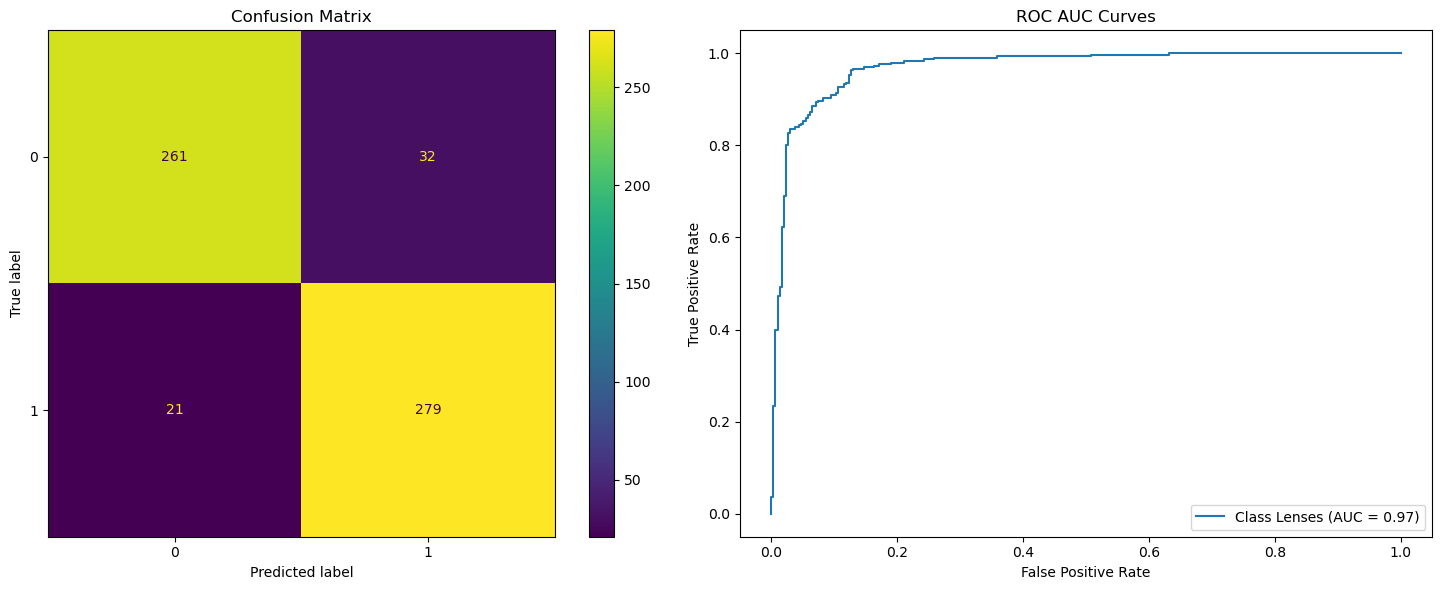

In [13]:
plot_cm_roc(output, y_true)

### Test scores when the model is run on the entire dataset 

In [14]:
output, y_true, acc, auc = test_(lp_network, dataloader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       1886       |          63         |
| true nonlenses |        45        |         1955        |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 97.2651% |
|    loss   |  0.0049  |
| auc score |  0.9936  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9767  | 0.9677 |  0.9722 |   1949  |
|   nonlenses    |   0.9688  | 0.9775 |  0.9731 |   2000  |
| macro averaged |   0.9727  | 0.9726 |  0.9726 |         |
+----------------+-----------+--------+---------+---------+


In [15]:
with open("./classifier_network.pth", "wb") as f:
    pickle.dump(lp_network, f)